In [3]:
# from: https://www.tensorflow.org/tutorials/keras/text_classification

# all the prerequisites
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
print(tf.__version__)
print ('All prerequisities imported.')

2.15.0
All prerequisities imported.


In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar = True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
print('dataset import and loading done.')

84125825/84125825 [==============================] - 8s 0us/step
dataset import and loading done.


In [6]:
# checking directory contents
os.listdir(dataset_dir)
# you can also see this via terminal
#shiva@ml-ai01:~/git/ML-AI/jupyternb$ ls aclImdb
#imdbEr.txt  imdb.vocab  README  test  train
#shiva@ml-ai01:~/git/ML-AI/jupyternb$

['test', 'imdb.vocab', 'README', 'train', 'imdbEr.txt']

In [9]:
#setup the training dir
train_dir = os.path.join(dataset_dir, 'train')
print ('Training data dir = ', os.listdir(train_dir))
print ('pos dir contains +ve review and neg dir contains -ve reviews')
print ('the +ve, -ve distribution is even, so that weight is not lopsided on one classification')

Training data dir =  ['neg', 'urls_unsup.txt', 'labeledBow.feat', 'unsup', 'urls_pos.txt', 'urls_neg.txt', 'pos', 'unsupBow.feat']
pos dir contains +ve review and neg dir contains -ve reviews
the +ve, -ve distribution is even, so that weight is not lopsided on one classification


In [12]:
# The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. 
# Let's take a look at one of them.
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print('Title = ', f.name)
    print('Review = ', f.read())

print ('Sample review printed. The label +ve is the dir name, since this review comes from pos dir, this sentiment is +ve')

Title =  ./aclImdb/train/pos/1181_9.txt
Review =  Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.
Sample review printed. The label +ve is the dir name, since this review comes from pos dir, this sentiment is +ve


In [13]:
# As the IMDB dataset contains additional folders, you will remove them before using this utility.
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
print ('unneeded directories removed')

unneeded directories removed


In [15]:
# Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. 
# tf.data is a powerful collection of tools for working with data.
# When running a machine learning experiment, it is a best practice to divide your 
# dataset into three splits: train, validation, and test.
# The IMDB dataset has already been divided into train and test, but it lacks a validation set.
# Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

batch_size = 32
seed = 42

# Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or 
# to pass shuffle=False, so that the validation and training splits have no overlap.

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [16]:
#If you're new to tf.data, you can also iterate over the dataset and print out a few examples as follows.

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print ("Review", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

# clearly it's l,m,n,o,p,q .. i.e. n, neg = 0, and p, pos = 1 for classification purposes

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [17]:
# The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, 
# you can check the class_names property on the dataset.

print("Label 0 corresponds to ", raw_train_ds.class_names[0])
print ("Label 1 corresponds to ", raw_train_ds.class_names[1])

Label 0 corresponds to  neg
Label 1 corresponds to  pos


In [18]:
#Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews 
# from the training set for validation.

# Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or 
# to pass shuffle=False, so that the validation and training splits have no overlap.

# when we did this the 1st time, the subset was training, here it is validation

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)
print ('Done creating validation dataset')

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Done creating validation dataset


In [19]:
# creating the raw test dataset, notice, this is test, the training got split into training and validation
# this is test (real) or untrained dataset .. the model has not seen this before.

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

print ('setting up raw_test_ds completed.')

Found 25000 files belonging to 2 classes.
setting up raw_test_ds completed.


In [20]:
#Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.
# Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. 
# Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, 
# by splitting on whitespace). 
# Vectorization refers to converting tokens into numbers so they can be fed into a neural network. 
# All of these tasks can be accomplished with this layer.

# this function just removes HTML

def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

print ('custom_standardization function is setup') 

custom_standardization function is setup


In [21]:
# Next, you will create a TextVectorization layer. You will use this layer to standardize, tokenize, and vectorize our data. 
# You set the output_mode to int to create unique integer indices for each token.

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

print ('vectorized defined')

vectorized defined


In [22]:
# Next, you will call adapt to fit the state of the preprocessing layer to the dataset. 
# This will cause the model to build an index of strings to integers.
# Note: It's important to only use your training data when calling adapt (using the test set would leak information).

# notice we are only calling train .. 
train_text = raw_train_ds.map(lambda x,y: x)
vectorize_layer.adapt(train_text)

print('text-only dataset created, no labels yet')

text-only dataset created, no labels yet


In [24]:
#Let's create a function to see the result of using this layer to preprocess some data.

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

print ('vectorize_text function defined')

vectorize_text function defined


In [27]:
# retrieve a batch (of 32 reviews and labels) from the dataset
# hmm .. code doesn't pull 32 reviews, just 1.

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review:", first_review)
print("Label:", raw_test_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

# Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last"
# interesting, their run pulls a different movie than my run ... why? if the files are 
# arranged in order, perhaps not? need to investigate later.



Review: tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label: neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    

In [28]:
# You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.
# select numbers from the Vectorized View numbers

print("1 --> ", vectorize_layer.get_vocabulary()[1])
print("7 --> ", vectorize_layer.get_vocabulary()[7])
print("4 --> ", vectorize_layer.get_vocabulary()[4])
print("1233 --> ", vectorize_layer.get_vocabulary()[1233])
print("1021 --> ", vectorize_layer.get_vocabulary()[1021])
print("27 --> ", vectorize_layer.get_vocabulary()[27])

print('Vocabulary size" {}'.format(len(vectorize_layer.get_vocabulary())))


1 -->  [UNK]
7 -->  is
4 -->  a
1233 -->  tough
1021 -->  cop
27 -->  he
Vocabulary size" 10000


In [30]:
# You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization 
# layer you created earlier to the train, validation, and test dataset.

train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

print('datasets are prepared')

datasets are prepared


In [31]:
# Configure the dataset for performance
# These are two important methods you should use when loading data to make sure that I/O does not become blocking.
# .cache() keeps data in memory after it's loaded off disk. 
# This will ensure the dataset does not become a bottleneck while training your model. 
#If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.
# .prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

print ('configured datasets for performance using cache and prefetching')

configured datasets for performance using cache and prefetching


In [32]:
# It's time to create your neural network:

embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1)
])

print ('Model Summary = ', model.summary())
print ('model is created')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160017 (625.07 KB)
Trainable params: 160017 (625.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [34]:
# lets compile ...

# A model needs a loss function and an optimizer for training. 
# Since this is a binary (+ve/1 or -ve/0) classification problem and the model outputs a probability 
# (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

print('model compiled')

model compiled


In [55]:
# lets train ....

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

print ('training completed')

Epoch 1/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0252 - binary_accuracy: 0.9958 - val_loss: 0.6363 - val_binary_accuracy: 0.8622
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0238 - binary_accuracy: 0.9960 - val_loss: 0.6497 - val_binary_accuracy: 0.8624
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0225 - binary_accuracy: 0.9959 - val_loss: 0.6642 - val_binary_accuracy: 0.8612
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0219 - binary_accuracy: 0.9960 - val_loss: 0.6751 - val_binary_accuracy: 0.8632
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0205 - binary_accuracy: 0.9965 - val_loss: 0.6876 - val_binary_accuracy: 0.8608
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.0196 - binary_accuracy: 0.9970 - val_loss: 0.7013 - val_binary_accuracy: 0.8620
Epoch 7/10
625/625 [==============================] - 2s 4ms/ste

In [56]:
# evaluate the model

loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.9459 - binary_accuracy: 0.8318
Loss:  0.9458633661270142
Accuracy:  0.8318399786949158


In [57]:
# plot of accuracy and loss over time

history_dict = history.history
print(history_dict.keys())

print ('\nhistory data setup')

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

history data setup


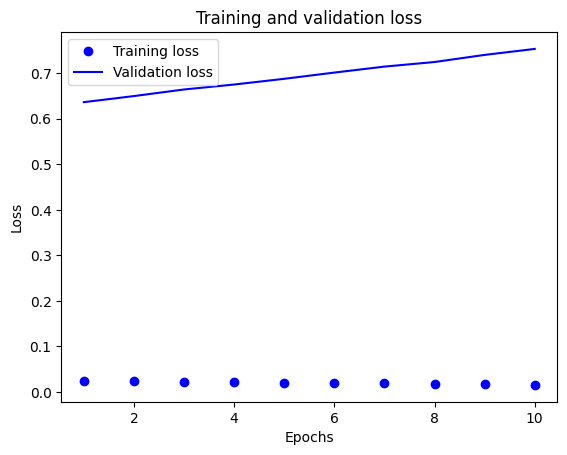

In [58]:
# plot

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo is for "blue dots"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line - Validation loss
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

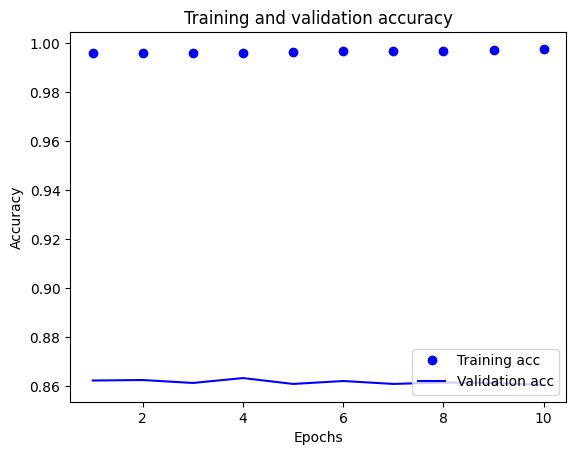

In [59]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [71]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 3s 3ms/step - loss: 0.9459 - accuracy: 0.8318
0.8318399786949158


In [80]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "Best movie ever!",
  "could not wait for the movie to end",
  "What a waste of time with this move",
  "The movie is fantastic",
  "terrific, I'd watch it again",
    "waste of time"
]

export_model.predict(examples, verbose=2)

1/1 - 0s - 31ms/epoch - 31ms/step


array([[0.7232987 ],
       [0.15645652],
       [0.11720741],
       [0.7616334 ],
       [0.44983342],
       [0.01137185],
       [0.84816414],
       [0.908514  ],
       [0.01974137]], dtype=float32)